## Data Cleansing을 해보자!
0. 환경설정, 데이터 불러오기
1. labeling error 제거
2. data split

### 0. 데이터 불러오기, 환경 설정

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer

from cleanlab.classification import CleanLearning

In [2]:
import matplotlib.pyplot as plt

import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
pd.set_option('display.max_colwidth', None)

##### 데이터 불러오기

In [5]:
clear_g2p_noise_all_train = pd.read_csv('/opt/level2_nlp_datacentric-nlp-12/data/clear_g2p_noise_all_train.csv')
print(clear_g2p_noise_all_train.shape)
clear_g2p_noise_all_train.head()

(45678, 5)


,ID,title_crawling,target,url,date
0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25
2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0008254585,2016.03.15. 오후 12:00
3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0009070646,2017.02.28. 오전 9:54
4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009999529,2018.04.03. 오전 7:05


### 1. labeling error 제거

In [7]:
raw_train_texts, raw_train_labels = clear_g2p_noise_all_train["text"].values, clear_g2p_noise_all_train["target"].values

In [8]:
num_classes = len(set(raw_train_labels))

i = 0
print(f"Example Label: {raw_train_labels[i]}")
print(f"Example Text: {raw_train_texts[i]}")


Example Label: 3
Example Text: 유튜브 내달 2일까지 크리에이터 지원 공간 운영


In [9]:
encoder = LabelEncoder()
encoder.fit(raw_train_labels)

train_labels = encoder.transform(raw_train_labels)

In [10]:
transformer = SentenceTransformer("Huffon/sentence-klue-roberta-base")

train_texts = transformer.encode(raw_train_texts)


No sentence-transformers model found with name /opt/ml/.cache/torch/sentence_transformers/Huffon_sentence-klue-roberta-base. Creating a new one with MEAN pooling.


In [11]:
train_texts[0].shape

(768,)

In [12]:
model = LogisticRegression(max_iter=2000)

In [13]:
cv_n_folds = 5  # for efficiency; values like 5 or 10 will generally work better

cl = CleanLearning(model, cv_n_folds=cv_n_folds)

In [14]:
label_issues = cl.find_label_issues(X=train_texts, labels=train_labels)
label_issues.head()

2023-06-01 03:20:26.541754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 03:20:26.855777: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-01 03:20:27.855844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-01 03:20:27.856005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,is_label_issue,label_quality,given_label,predicted_label
0,True,0.248428,3,2
1,False,0.969524,3,3
2,False,0.892332,2,2
3,True,0.200809,2,0
4,False,0.993102,3,3


In [15]:
def print_as_df(index):
    return pd.DataFrame(
        {
            "text": raw_train_texts,
            "given_label": raw_train_labels,
            "predicted_label": encoder.inverse_transform(label_issues["predicted_label"]),
            'score': round(label_issues["label_quality"], 5),
            'is_label_issue': label_issues["is_label_issue"]
        },
    ).iloc[index]

In [16]:
df = print_as_df(label_issues.index)
df

,text,given_label,predicted_label,score,is_label_issue
0,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,2,0.24843,True
1,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,3,0.96952,False
2,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,2,0.89233,False
3,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,0,0.20081,True
4,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,3,0.99310,False
...,...,...,...,...,...
45673,사우디 아람코 주요 석유시설·유전 드론 공격에 화재,4,4,0.93182,False
45674,박기원 감독 눈치 보지 말고…비예나 눈치 본 건 아닌데,5,5,0.82148,False
45675,아시안게임 첫 경기 앞둔 라건아 인도네시아 팬이라도 많으면 좋아,5,5,0.98262,False
45676,트럼프 미중 무역협상 1단계 합의 서명식 가질 것종합,4,4,0.97164,False


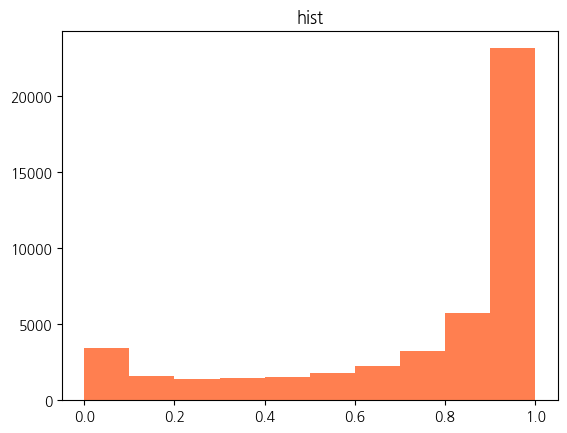

In [17]:
hist = plt.hist(df['score'], color = 'coral')
plt.title('hist')

plt.show()

In [34]:
identified_issues_false = df["score"] > 0.0110
print(identified_issues_false.value_counts())
not_labeling_error_df = clear_g2p_noise_all_train[identified_issues_false]
not_labeling_error_df.head(3)

score
True     44368
False     1310
Name: count, dtype: int64


,ID,title_crawling,target,url,date
0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25
2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0008254585,2016.03.15. 오후 12:00
3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0009070646,2017.02.28. 오전 9:54
4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009999529,2018.04.03. 오전 7:05
...,...,...,...,...,...
45673,ynat-v1_train_45673,사우디 아람코 주요 석유시설·유전 드론 공격에 화재,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=234&oid=001&aid=0011080278,2019.09.14. 오후 4:36
45674,ynat-v1_train_45674,박기원 감독 눈치 보지 말고…비예나 눈치 본 건 아닌데,5,https://sports.news.naver.com/news.nhn?oid=001&aid=0011186865,2019.11.03 17:06
45675,ynat-v1_train_45675,아시안게임 첫 경기 앞둔 라건아 인도네시아 팬이라도 많으면 좋아,5,https://sports.news.naver.com/news.nhn?oid=001&aid=0010267768,2018.08.13 17:54
45676,ynat-v1_train_45676,트럼프 미중 무역협상 1단계 합의 서명식 가질 것종합,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0011297568,2019.12.25. 오후 4:36


In [31]:
identified_issues = df["score"] <= 0.0110
print(identified_issues.value_counts())
labeling_error_df = clear_g2p_noise_all_train[identified_issues]
labeling_error_df

score
False    44368
True      1310
Name: count, dtype: int64


,ID,title_crawling,target,url,date
49,ynat-v1_train_00049,반민특위 임무 아직 끝나지 않았다,5,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0010865896,2019.06.03. 오후 4:11
156,ynat-v1_train_00156,경찰 축구대표팀 달걀 봉변 수사 않기로…처벌 불원,2,https://sports.news.naver.com/news.nhn?oid=001&aid=0010186826,2018.07.03 10:14
195,ynat-v1_train_00195,정부 편안하게 여행할 수 있는 관광복지 사회 위해 지원,6,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=237&oid=001&aid=0009435190,2017.07.26. 오후 3:18
198,ynat-v1_train_00198,예스24 영어학습서 40대가 가장 많이 산다,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009943437,2018.03.08. 오전 11:34
250,ynat-v1_train_00250,트럼프·엡스타인 1992년 마러라고서 여성 20여명과 파티,1,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0010944745,2019.07.11. 오전 6:18
...,...,...,...,...,...
45343,ynat-v1_train_45343,포워드컴퍼니스 50억원 규모 유상증자 결정,6,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=261&oid=001&aid=0009609966,2017.10.16. 오후 5:05
45377,ynat-v1_train_45377,김철수 한전 감독 아텀 이르면 다음 주 복귀 기대,6,https://sports.news.naver.com/news.nhn?oid=001&aid=0010457061,2018.11.08 18:41
45399,ynat-v1_train_45399,1승 11패 한국 여자배구 VNL 5주차서 벼랑 끝 승부,0,https://sports.news.naver.com/news.nhn?oid=001&aid=0010893428,2019.06.16 06:44
45436,ynat-v1_train_45436,美 수배받은 콜롬비아 최대 반군 전 사령관 의원으로 취임,0,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0010883789,2019.06.12. 오전 4:51


In [33]:
labeling_error_df['target'] = df['predicted_label']
labeling_error_df

/tmp/ipykernel_7873/966780108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeling_error_df['target'] = df['predicted_label']


,ID,title_crawling,target,url,date
49,ynat-v1_train_00049,반민특위 임무 아직 끝나지 않았다,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0010865896,2019.06.03. 오후 4:11
156,ynat-v1_train_00156,경찰 축구대표팀 달걀 봉변 수사 않기로…처벌 불원,5,https://sports.news.naver.com/news.nhn?oid=001&aid=0010186826,2018.07.03 10:14
195,ynat-v1_train_00195,정부 편안하게 여행할 수 있는 관광복지 사회 위해 지원,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=237&oid=001&aid=0009435190,2017.07.26. 오후 3:18
198,ynat-v1_train_00198,예스24 영어학습서 40대가 가장 많이 산다,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009943437,2018.03.08. 오전 11:34
250,ynat-v1_train_00250,트럼프·엡스타인 1992년 마러라고서 여성 20여명과 파티,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0010944745,2019.07.11. 오전 6:18
...,...,...,...,...,...
45343,ynat-v1_train_45343,포워드컴퍼니스 50억원 규모 유상증자 결정,1,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=261&oid=001&aid=0009609966,2017.10.16. 오후 5:05
45377,ynat-v1_train_45377,김철수 한전 감독 아텀 이르면 다음 주 복귀 기대,5,https://sports.news.naver.com/news.nhn?oid=001&aid=0010457061,2018.11.08 18:41
45399,ynat-v1_train_45399,1승 11패 한국 여자배구 VNL 5주차서 벼랑 끝 승부,5,https://sports.news.naver.com/news.nhn?oid=001&aid=0010893428,2019.06.16 06:44
45436,ynat-v1_train_45436,美 수배받은 콜롬비아 최대 반군 전 사령관 의원으로 취임,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0010883789,2019.06.12. 오전 4:51


In [35]:
clear_labeling_error_all_train = pd.concat([not_labeling_error_df, labeling_error_df], axis=0)
clear_labeling_error_all_train

,ID,title_crawling,target,url,date
0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25
2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0008254585,2016.03.15. 오후 12:00
3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0009070646,2017.02.28. 오전 9:54
4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009999529,2018.04.03. 오전 7:05
...,...,...,...,...,...
45343,ynat-v1_train_45343,포워드컴퍼니스 50억원 규모 유상증자 결정,1,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=261&oid=001&aid=0009609966,2017.10.16. 오후 5:05
45377,ynat-v1_train_45377,김철수 한전 감독 아텀 이르면 다음 주 복귀 기대,5,https://sports.news.naver.com/news.nhn?oid=001&aid=0010457061,2018.11.08 18:41
45399,ynat-v1_train_45399,1승 11패 한국 여자배구 VNL 5주차서 벼랑 끝 승부,5,https://sports.news.naver.com/news.nhn?oid=001&aid=0010893428,2019.06.16 06:44
45436,ynat-v1_train_45436,美 수배받은 콜롬비아 최대 반군 전 사령관 의원으로 취임,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0010883789,2019.06.12. 오전 4:51


In [36]:
clear_labeling_error_all_train.to_csv('/opt/level2_nlp_datacentric-nlp-12/data/clear_labeling_error_all_train.csv', sep = ',', index=False)

### 2. data split
- train 0.7, val 0.3

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
dataset_train, dataset_valid = train_test_split(clear_labeling_error_all_train, test_size=0.3, random_state=456)  # SEED 는 정해져 있음

In [ ]:
dataset_train.to_csv('/opt/level2_nlp_datacentric-nlp-12/data/train.csv', sep = ',', index=False)
dataset_valid.to_csv('/opt/level2_nlp_datacentric-nlp-12/data/dev.csv', sep = ',', index=False)